In [5]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\helper")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\mujoco_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\gpt_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\detection_module")

from mujoco_parser import *
from utility import *
from transformation import *

#sys.path.append('../package/helper/')
#sys.path.append('../package/mujoco_usage/')
#sys.path.append('../package/gpt_usage/')
#sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready.


In [14]:
# capture_and_save_fixed.py
# Fixed version with proper coordinate system handling for object detection alignment
# Dependencies: mujoco, mujoco.glfw, PyOpenGL, numpy, pillow

import os
import numpy as np
from PIL import Image
import mujoco as mj
from mujoco.glfw import glfw
import OpenGL.GL as gl

# ========= User Config =========
XML_PATH = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"
CAM_NAME = "standing_cam"
WINDOW_W, WINDOW_H = 1200, 900
OUT_PATH = "frame_pack.npz"
SAVE_DEPTH01 = True
USE_CV_CONVENTION = True  # Set True for computer vision convention (recommended)
# ===============================

def linearize_depth_buffer(depth01, near, far):
    """Convert normalized depth buffer [0,1] to linear depth values"""
    depth01 = np.asarray(depth01, dtype=np.float32)
    z_ndc = depth01 * 2.0 - 1.0  # [-1, 1]
    d = (2.0 * near * far) / (far + near - z_ndc * (far - near))
    return d

def intrinsics_from_fovy(fovy_deg, width, height):
    """Calculate camera intrinsics from field of view"""
    H, W = height, width
    fovy_rad = np.deg2rad(float(fovy_deg))
    fy = H / (2.0 * np.tan(fovy_rad / 2.0))
    fx = fy  # Assuming square pixels
    cx = (W - 1) / 2.0
    cy = (H - 1) / 2.0
    return fx, fy, cx, cy

def depth_to_camera_xyz_cv(depth01, fovy_deg, near, far):
    """
    Convert depth to camera coordinates using Computer Vision convention:
    - X: right, Y: down, Z: forward (into scene)
    - Compatible with most object detection libraries
    """
    H, W = depth01.shape
    fx, fy, cx, cy = intrinsics_from_fovy(fovy_deg, W, H)
    d = linearize_depth_buffer(depth01, near, far)  # positive distance
    
    u = np.arange(W, dtype=np.float32)
    v = np.arange(H, dtype=np.float32)
    uu, vv = np.meshgrid(u, v)
    
    X = (uu - cx) / fx * d  # Right: positive
    Y = (vv - cy) / fy * d  # Down: positive (NO negative sign)
    Z = d                   # Forward: positive (NO negative sign)
    
    return np.stack([X, Y, Z], axis=-1)

def depth_to_camera_xyz_opengl(depth01, fovy_deg, near, far):
    """
    Convert depth to camera coordinates using OpenGL convention:
    - X: right, Y: up, Z: backward (out of screen)
    - Original implementation
    """
    H, W = depth01.shape
    fx, fy, cx, cy = intrinsics_from_fovy(fovy_deg, W, H)
    d = linearize_depth_buffer(depth01, near, far)  # positive forward
    
    u = np.arange(W, dtype=np.float32)
    v = np.arange(H, dtype=np.float32)
    uu, vv = np.meshgrid(u, v)
    
    X = (uu - cx) / fx * d
    Y = -(vv - cy) / fy * d  # Negative for up
    Z = -d                   # Negative for backward
    
    return np.stack([X, Y, Z], axis=-1)

def camera_to_world_cv(xyz_cam, cam_pos, cam_xmat):
    """
    Transform CV camera coordinates to world coordinates
    Converts from CV convention to MuJoCo convention first
    """
    H, W, _ = xyz_cam.shape
    pts = xyz_cam.reshape(-1, 3)
    
    # Convert CV camera coords to MuJoCo camera coords
    # CV: (X_right, Y_down, Z_forward) -> MuJoCo cam: (X_right, Y_up, Z_back)
    pts_mj = pts.copy()
    pts_mj[:, 1] = -pts[:, 1]  # Y: down -> up
    pts_mj[:, 2] = -pts[:, 2]  # Z: forward -> backward
    
    # Transform to world coordinates
    R = cam_xmat.reshape(3, 3)
    pts_world = pts_mj @ R.T + cam_pos
    
    return pts_world.reshape(H, W, 3)

def camera_to_world_points(xyz_cam, cam_pos, cam_xmat):
    """Original OpenGL convention transformation"""
    R = cam_xmat.reshape(3, 3)
    H, W, _ = xyz_cam.shape
    pts = xyz_cam.reshape(-1, 3)
    pts_world = pts @ R.T + cam_pos  # Nx3
    return pts_world.reshape(H, W, 3)

def world_to_image_coords(xyz_world, cam_pos, cam_xmat, fovy_deg, width, height, use_cv=True):
    """
    Project 3D world points back to image coordinates for verification
    """
    # Transform world to camera coordinates
    R = cam_xmat.reshape(3, 3)
    xyz_cam_mj = (xyz_world.reshape(-1, 3) - cam_pos) @ R
    
    # Get camera intrinsics
    fx, fy, cx, cy = intrinsics_from_fovy(fovy_deg, width, height)
    
    if use_cv:
        # Convert MuJoCo camera coords to CV camera coords
        # MuJoCo: (X_right, Y_up, Z_back) -> CV: (X_right, Y_down, Z_forward)
        X, Y, Z = xyz_cam_mj[:, 0], -xyz_cam_mj[:, 1], -xyz_cam_mj[:, 2]
        
        # Project using CV convention
        u = (X / Z) * fx + cx
        v = (Y / Z) * fy + cy
    else:
        # Use original OpenGL convention
        X, Y, Z = xyz_cam_mj[:, 0], xyz_cam_mj[:, 1], xyz_cam_mj[:, 2]
        u = (X / (-Z)) * fx + cx
        v = (-Y / (-Z)) * fy + cy
    
    return np.column_stack([u, v]).reshape(xyz_world.shape[:2] + (2,))

def validate_reconstruction(rgba, xyz_world, cam_pos, cam_xmat, fovy_deg, use_cv=True):
    """
    Test reconstruction by projecting known 3D points back to image
    """
    H, W = xyz_world.shape[:2]
    print(f"\n🔍 **Validating Reconstruction** ({'CV' if use_cv else 'OpenGL'} convention)")
    print("=" * 50)
    
    # Test multiple points
    test_points = [
        (W // 2, H // 2, "Center"),
        (W // 4, H // 4, "Top-left quarter"),
        (3 * W // 4, 3 * H // 4, "Bottom-right quarter"),
        (0, 0, "Top-left corner"),
        (W - 1, H - 1, "Bottom-right corner")
    ]
    
    max_error = 0
    for u, v, name in test_points:
        if 0 <= u < W and 0 <= v < H:
            # Get 3D point
            point_3d = xyz_world[v, u]
            
            # Skip invalid points
            if not np.isfinite(point_3d).all():
                print(f"❌ {name} ({u}, {v}): Invalid 3D point")
                continue
            
            # Project back to image
            projected = world_to_image_coords(
                point_3d.reshape(1, 1, 3), cam_pos, cam_xmat, fovy_deg, W, H, use_cv
            )
            proj_u, proj_v = projected[0, 0]
            
            # Calculate error
            error_u = abs(proj_u - u)
            error_v = abs(proj_v - v)
            total_error = np.sqrt(error_u**2 + error_v**2)
            max_error = max(max_error, total_error)
            
            status = "✅" if total_error < 2.0 else "⚠️" if total_error < 5.0 else "❌"
            print(f"{status} {name} ({u}, {v})")
            print(f"   3D: [{point_3d[0]:.3f}, {point_3d[1]:.3f}, {point_3d[2]:.3f}]")
            print(f"   Projected: ({proj_u:.1f}, {proj_v:.1f})")
            print(f"   Error: u={error_u:.2f}, v={error_v:.2f}, total={total_error:.2f}px")
            print()
    
    print(f"📊 **Max reprojection error: {max_error:.2f} pixels**")
    
    if max_error < 2.0:
        print("✅ **EXCELLENT**: Reconstruction is highly accurate!")
    elif max_error < 5.0:
        print("⚠️  **GOOD**: Reconstruction has minor errors, should work for most applications.")
    else:
        print("❌ **POOR**: Reconstruction has significant errors. Check coordinate system!")
    
    return max_error < 5.0

def render_and_capture(model, data, cam_name, window_size):
    """Render scene and capture RGBA + depth"""
    WINDOW_W, WINDOW_H = window_size
    if not glfw.init():
        raise RuntimeError("Failed to initialize GLFW")
    
    glfw.window_hint(glfw.VISIBLE, glfw.TRUE)
    window = glfw.create_window(WINDOW_W, WINDOW_H, "MuJoCo Capture", None, None)
    if not window:
        glfw.terminate()
        raise RuntimeError("Failed to create GLFW window")
    
    glfw.make_context_current(window)
    glfw.swap_interval(1)

    cam = mj.MjvCamera()
    opt = mj.MjvOption()
    mj.mjv_defaultCamera(cam)
    mj.mjv_defaultOption(opt)
    scene = mj.MjvScene(model, maxgeom=10000)
    context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

    # Set fixed camera by name
    try:
        cam_id = model.camera(cam_name).id
    except Exception:
        cam_id = mj.mj_name2id(model, mj.mjtObj.mjOBJ_CAMERA, cam_name)
        if cam_id < 0:
            glfw.destroy_window(window)
            glfw.terminate()
            raise ValueError(f"Camera '{cam_name}' not found.")
    
    cam.type = mj.mjtCamera.mjCAMERA_FIXED
    cam.fixedcamid = cam_id

    # Forward simulation and render
    mj.mj_forward(model, data)
    fb_w, fb_h = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, fb_w, fb_h)
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)

    # Read RGBA and depth (flip to top-left origin)
    rgba_bytes = gl.glReadPixels(0, 0, fb_w, fb_h, gl.GL_RGBA, gl.GL_UNSIGNED_BYTE)
    rgba = np.frombuffer(rgba_bytes, dtype=np.uint8).reshape(fb_h, fb_w, 4)
    rgba = np.flip(rgba, axis=0)

    depth_bytes = gl.glReadPixels(0, 0, fb_w, fb_h, gl.GL_DEPTH_COMPONENT, gl.GL_FLOAT)
    depth01 = np.frombuffer(depth_bytes, dtype=np.float32).reshape(fb_h, fb_w)
    depth01 = np.flip(depth01, axis=0)

    # Get camera parameters
    near = float(model.vis.map.znear) if getattr(model.vis.map, "znear", 0.0) > 0 else 0.01
    far_default = max(50.0, 5.0 * float(model.stat.extent))
    far = float(model.vis.map.zfar) if getattr(model.vis.map, "zfar", 0.0) > 0 else far_default
    
    if not (near > 0 and far > near):
        glfw.destroy_window(window)
        glfw.terminate()
        raise ValueError(f"Invalid near/far: near={near}, far={far}")

    fovy_deg = float(model.cam_fovy[cam_id])
    cam_pos = data.cam_xpos[cam_id].copy()
    cam_xmat = data.cam_xmat[cam_id].copy()

    glfw.destroy_window(window)
    glfw.terminate()

    return rgba, depth01, fovy_deg, near, far, cam_pos, cam_xmat

def create_debug_visualization(rgba, xyz_world, valid_mask):
    """Create debug images showing depth and 3D coordinates"""
    from PIL import ImageDraw, ImageFont
    
    # Create depth visualization
    depth_vis = np.zeros_like(rgba[:, :, :3])
    if np.any(valid_mask):
        z_values = xyz_world[:, :, 2]
        z_valid = z_values[valid_mask > 0]
        z_min, z_max = np.percentile(z_valid, [5, 95])
        z_norm = np.clip((z_values - z_min) / (z_max - z_min), 0, 1)
        depth_vis = (z_norm[..., None] * np.array([255, 255, 255])).astype(np.uint8)
    
    # Save debug images
    Image.fromarray(rgba[:, :, :3]).save("debug_rgb.png")
    Image.fromarray(depth_vis).save("debug_depth.png")
    
    print("📸 **Debug images saved:**")
    print("   - debug_rgb.png (RGB capture)")
    print("   - debug_depth.png (Depth visualization)")

def main():
    print("🚀 **Loading MuJoCo model...**")
    model = mj.MjModel.from_xml_path(XML_PATH)
    data = mj.MjData(model)

    print("🎥 **Rendering and capturing scene...**")
    rgba, depth01, fovy_deg, near, far, cam_pos, cam_xmat = render_and_capture(
        model, data, CAM_NAME, (WINDOW_W, WINDOW_H)
    )

    print("🧮 **Reconstructing 3D coordinates...**")
    if USE_CV_CONVENTION:
        print("   Using Computer Vision convention (X:right, Y:down, Z:forward)")
        xyz_cam = depth_to_camera_xyz_cv(depth01, fovy_deg, near, far)
        xyz_world = camera_to_world_cv(xyz_cam, cam_pos, cam_xmat)
    else:
        print("   Using OpenGL convention (X:right, Y:up, Z:backward)")
        xyz_cam = depth_to_camera_xyz_opengl(depth01, fovy_deg, near, far)
        xyz_world = camera_to_world_points(xyz_cam, cam_pos, cam_xmat)

    # Validity mask: finite and not at far plane
    valid_mask = np.isfinite(depth01) & (depth01 < 0.999)

    print("✅ **Validating coordinate system accuracy...**")
    is_valid = validate_reconstruction(rgba, xyz_world, cam_pos, cam_xmat, fovy_deg, USE_CV_CONVENTION)
    
    if not is_valid:
        print("⚠️  **WARNING**: High reprojection errors detected!")
        print("   Consider switching coordinate conventions or checking camera parameters.")

    print("💾 **Saving results...**")
    # Save comprehensive data pack
    save_dict = dict(
        rgba=rgba,
        xyz_world=xyz_world.astype(np.float32),
        xyz_cam=xyz_cam.astype(np.float32),
        valid_mask=valid_mask.astype(np.uint8),
        cam_pos=cam_pos.astype(np.float32),
        cam_xmat=cam_xmat.astype(np.float32),
        meta=np.array([fovy_deg, near, far], dtype=np.float32),
        convention=np.array([USE_CV_CONVENTION], dtype=bool),  # Track which convention used
    )
    
    if SAVE_DEPTH01:
        save_dict["depth01"] = depth01.astype(np.float32)

    np.savez_compressed(OUT_PATH, **save_dict)
    Image.fromarray(rgba).save("rgb_capture.png")
    
    # Create debug visualizations
    create_debug_visualization(rgba, xyz_world, valid_mask)

    # Print summary
    H, W = depth01.shape
    valid_pixels = np.sum(valid_mask)
    print("\n📋 **Summary:**")
    print("=" * 40)
    print(f"✅ Saved: {OUT_PATH}")
    print(f"✅ Saved: rgb_capture.png")
    print(f"📐 Image size: {W}×{H}")
    print(f"🎯 Valid pixels: {valid_pixels:,} / {H*W:,} ({100*valid_pixels/(H*W):.1f}%)")
    print(f"📷 Camera FOV: {fovy_deg:.1f}°")
    print(f"🔍 Depth range: {near:.4f} - {far:.2f}")
    print(f"🧭 Coordinate system: {'Computer Vision' if USE_CV_CONVENTION else 'OpenGL'}")
    print(f"🌍 Camera position: [{cam_pos[0]:.3f}, {cam_pos[1]:.3f}, {cam_pos[2]:.3f}]")
    
    # Data shapes
    print(f"\n📊 **Data shapes:**")
    print(f"   rgba: {rgba.shape}")
    print(f"   depth01: {depth01.shape}")
    print(f"   xyz_world: {xyz_world.shape}")
    print(f"   xyz_cam: {xyz_cam.shape}")

if __name__ == "__main__":
    main()


🚀 **Loading MuJoCo model...**
🎥 **Rendering and capturing scene...**
🧮 **Reconstructing 3D coordinates...**
   Using Computer Vision convention (X:right, Y:down, Z:forward)
✅ **Validating coordinate system accuracy...**

🔍 **Validating Reconstruction** (CV convention)
✅ Center (600, 450)
   3D: [2.542, 0.000, 2.244]
   Projected: (600.0, 450.0)
   Error: u=0.00, v=0.00, total=0.00px

✅ Top-left quarter (300, 225)
   3D: [2.541, -0.003, 2.245]
   Projected: (300.0, 225.0)
   Error: u=0.00, v=0.00, total=0.00px

✅ Bottom-right quarter (900, 675)
   3D: [2.543, 0.003, 2.242]
   Projected: (900.0, 675.0)
   Error: u=0.00, v=0.00, total=0.00px

✅ Top-left corner (0, 0)
   3D: [2.540, -0.006, 2.247]
   Projected: (0.0, 0.0)
   Error: u=0.00, v=0.00, total=0.00px

✅ Bottom-right corner (1199, 899)
   3D: [2.545, 0.006, 2.240]
   Projected: (1199.0, 899.0)
   Error: u=0.00, v=0.00, total=0.00px

📊 **Max reprojection error: 0.00 pixels**
✅ **EXCELLENT**: Reconstruction is highly accurate!
💾 **S

In [15]:
from PIL import Image
png_path = r'C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\camera_capture.png'
img = Image.open(png_path)   # PIL Image object
img.show()

In [16]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = r"C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt",
)
print ("Ready.")

key_path:[C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-anot
her-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

Ready.


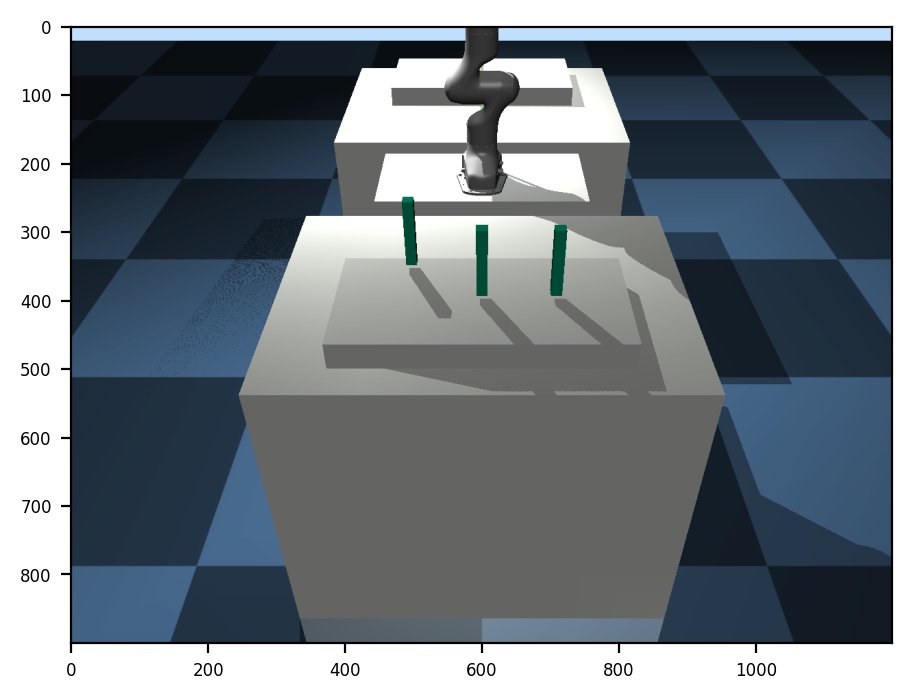

[USER_MSG]

<img1>Describe the image.

[GPT_OUTPUT]

The image shows a mechanical arm positioned above a platform with three upright green cylindrical objects. The arm appears to be part of a robotic setup, likely for manipulating or interacting with the objects. The scene is set on a checkered floor, and there are two platforms with the arm extending towards the one in the foreground. The lighting casts shadows from the objects onto the surface of the platform.

[USER_MSG]


        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand.very small.
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        

[GPT_OUTPUT]

Certainly! Based on the image, the JSON format for detectable objects could look like this:

```json
{
  "objects": [
    "small green cylinder"
  ]
}
```

This format lists objects that are smaller than the robotic hand and suitable for picking up.

Done.


In [17]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand.very small.
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

object_names:['small green cylinder']


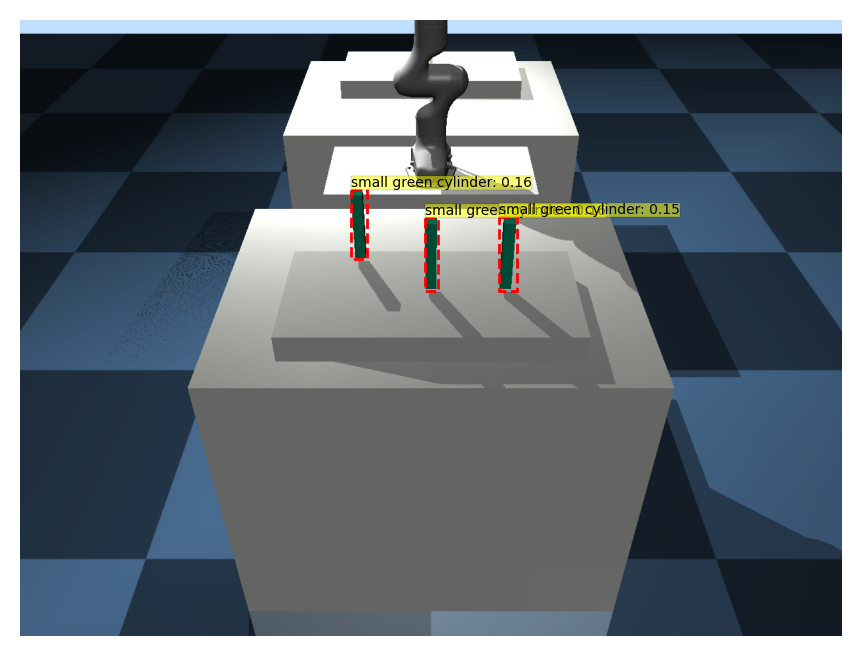

Saved boxes.npy: (3, 4)
Saved labels.npy: (3,)


C:\Users\ptfc0\AppData\Local\Temp\ipykernel_25832\2437289462.py:45: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(labels, dtype=object)


In [19]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.1,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)

boxes = detection_result['boxes']  # Expecting (N,4) XYXY in png_path pixel coords
if hasattr(boxes, "detach"):  # torch.Tensor
    boxes = boxes.detach().cpu().numpy()
else:
    boxes = np.asarray(boxes, dtype=np.float32)

np.save("boxes.npy", boxes.astype(np.float32))
print("Saved boxes.npy:", boxes.shape)

# 2) (Optional but recommended) Save labels/names per detection if available
labels = None
for key in ["labels", "names", "texts", "class_names"]:
    if key in detection_result:
        labels = detection_result[key]
        break

# If the model returns class indices that map into your queried object_names:
if labels is None and "class_ids" in detection_result:
    class_ids = detection_result["class_ids"]
    labels = [object_names[i] for i in class_ids]

if labels is not None:
    labels = np.array(labels, dtype=object)
    np.save("labels.npy", labels)
    print("Saved labels.npy:", labels.shape)
else:
    print("No labels field found in detection_result; proceeding with boxes only.")


In [23]:
# Quick load for immediate use
data = np.load('frame_pack.npz')
ego_rgb_img, xyz_img_world = data['rgba'][:,:,:3], data['xyz_world']
valid_mask = data['valid_mask']  # Don't forget this!

# Your detection code with tensor conversion
xyz_bboxes = []

for i, box in enumerate(detection_result['boxes']):  # for each detection box
    # Convert PyTorch tensor to numpy array first
    box_np = box.detach().cpu().numpy()  # Handles GPU tensors and gradients safely
    
    # Scale bounding box coordinates to match xyz_img_world resolution
    scale_factor = xyz_img_world.shape[0] / ego_rgb_img.shape[0]
    x1, y1, x2, y2 = (box_np * scale_factor).astype(int)
    
    # Ensure bounds are within image
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(xyz_img_world.shape[1] - 1, x2)
    y2 = min(xyz_img_world.shape[0] - 1, y2)
    
    print(f"Detection {i} bbox (scaled): x1={x1}, y1={y1}, x2={x2}, y2={y2}")

    # Extract xyz points inside bbox
    xyz = xyz_img_world[y1:y2+1, x1:x2+1, :].reshape((-1, 3))  # [M x 3]
    
    # Filter using valid mask
    if valid_mask is not None:
        bbox_mask = valid_mask[y1:y2+1, x1:x2+1].reshape((-1,))
        xyz = xyz[bbox_mask > 0]
    
    # Remove invalid points
    finite_mask = np.isfinite(xyz).all(axis=1)
    xyz = xyz[finite_mask]
    
    print(f"Detection {i} - number of points in bbox: {xyz.shape[0]}")

    if xyz.shape[0] > 0:
        xyz_bboxes.append(xyz)  # append pcd xyz of bbox

# Continue with your existing code...
xyz_bboxes_unique = exclude_overlapping_pcd_within_list(xyz_bboxes)

# Rest of your processing code remains the same
xyz_objects, xyz_centers = [], []

for i, xyz in enumerate(xyz_bboxes_unique):
    print(f"\nObject {i} - Number of points before filtering: {xyz.shape[0]}")

    # Discretize height to detect floor
    z_discretized = np.round(xyz[:, 2] / 0.01) * 0.01
    unique, counts = np.unique(z_discretized, return_counts=True)
    
    print(f"Object {i} - unique z bins: {unique}")
    print(f"Object {i} - counts per bin: {counts}")
    
    k = int(len(unique) * 0.5)
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]
    z_floor = np.min(top_k_unique_values) + 0.005

    print(f"Object {i} - Estimated floor height (z_floor): {z_floor}")

    # Filter points above floor + offset
    xyz_object = xyz[xyz[:, 2] >= z_floor]
    print(f"Object {i} - Number of points after filtering: {xyz_object.shape[0]}")

    # Fit circle only if enough points
    if xyz_object.shape[0] < 10:
        print(f"Object {i} - Not enough points to fit circle.")
        continue

    xy_object = xyz_object[:, :2]
    xy_center, radius = fit_xy_circle(xy_object)
    center_3d = np.append(xy_center, z_floor)
    xyz_centers.append(center_3d)

    # Print 3D world coordinate center for verification
    print(f"Object {i} - 3D world center: x={center_3d[0]:.3f}, y={center_3d[1]:.3f}, z={center_3d[2]:.3f}")

print("Done.")


Detection 0 bbox (scaled): x1=483, y1=247, x2=506, y2=348
Detection 0 - number of points in bbox: 2448
Detection 1 bbox (scaled): x1=591, y1=288, x2=609, y2=395
Detection 1 - number of points in bbox: 2052
Detection 2 bbox (scaled): x1=698, y1=287, x2=725, y2=395
Detection 2 - number of points in bbox: 3052

Object 0 - Number of points before filtering: 2448
Object 0 - unique z bins: [2.24 2.25]
Object 0 - counts per bin: [2016  432]
Object 0 - Estimated floor height (z_floor): 2.245000123977661
Object 0 - Number of points after filtering: 432
Object 0 - 3D world center: x=2.542, y=-0.000, z=2.245

Object 1 - Number of points before filtering: 2052
Object 1 - unique z bins: [2.24]
Object 1 - counts per bin: [2052]
Object 1 - Estimated floor height (z_floor): 2.245000123977661
Object 1 - Number of points after filtering: 0
Object 1 - Not enough points to fit circle.

Object 2 - Number of points before filtering: 3052
Object 2 - unique z bins: [2.24]
Object 2 - counts per bin: [3052]
Obj

In [43]:
# overhead_multicolor_pixel_to_world.py
# Requirements: pip install mujoco glfw PyOpenGL pillow numpy

import numpy as np
import mujoco as mj
from mujoco.glfw import glfw
import OpenGL.GL as gl
from PIL import Image, ImageDraw

# --------- User config ---------
XML_PATH = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"
CAM_NAME = "overhead_cam"
WINDOW_SIZE = (1200, 900)     # good coverage and resolution
USE_CV_CONVENTION = True      # X right, Y down, Z forward (image coords)

# If auto table detection fails, fallback here (blocks at z=1.2, half-height=0.1 -> ~1.1)
Z_TABLE_FALLBACK = 1.0

# Define color classes (reference RGB in [0..255], per-channel tolerance)
# Tune 'tol' if masks are too tight/loose (45–70 is typical for MJCF renders).
COLOR_CLASSES = {
    # Teal block geom: rgba="0.0 0.7 0.5 1"  -> (0, 179, 128)
    "teal_block": {"ref_rgb": (0, 255, 0), "tol": 55},
    # Red targets: rgba="1 0 0 1" -> (255, 0, 0)
    "red_target": {"ref_rgb": (255, 0, 0), "tol": 60},
    # Add more if needed, e.g. pure blue:
    # "blue_thing": {"ref_rgb": (0, 0, 255), "tol": 60},
}

# Grid-based clustering settings (dependency-free connected grouping)
GRID = 48          # increase for finer separation of nearby blobs
MIN_PIXELS = 80    # minimum pixels per grid cell to consider it occupied
# --------------------------------


def intrinsics_from_fovy(fovy_deg, width, height):
    H, W = height, width
    fovy_rad = np.deg2rad(float(fovy_deg))
    fy = H / (2.0 * np.tan(fovy_rad / 2.0))
    fx = fy
    cx = (W - 1) / 2.0
    cy = (H - 1) / 2.0
    return fx, fy, cx, cy


def pixel_to_world_xy(u, v, W, H, fovy_deg, cam_pos, cam_xmat, z_plane=0.0, use_cv=True):
    fx, fy, cx, cy = intrinsics_from_fovy(fovy_deg, W, H)

    # Camera-space ray (CV convention)
    x_cv = (u - cx) / fx
    y_cv = (v - cy) / fy
    d_cam_cv = np.array([x_cv, y_cv, 1.0], dtype=np.float32)

    # Convert to MuJoCo camera coords (X right, Y up, Z back)
    if use_cv:
        d_cam_mj = np.array([d_cam_cv[0], -d_cam_cv[1], -d_cam_cv[2]], dtype=np.float32)
    else:
        d_cam_mj = np.array([x_cv, y_cv, -1.0], dtype=np.float32)

    d_cam_mj /= np.linalg.norm(d_cam_mj) + 1e-12

    # World direction: d_world = d_cam_mj @ R^T (R is world->cam)
    R = cam_xmat.reshape(3, 3)
    d_world = d_cam_mj @ R.T
    o = cam_pos  # camera origin

    if abs(d_world[2]) < 1e-12:
        return None

    t = (z_plane - o[2]) / d_world[2]
    if t < 0:
        return None

    p = o + t * d_world
    return p  # [X, Y, Z=z_plane]


def mask_from_ref_rgb(rgb, ref_rgb, tol):
    """
    Build a mask using Chebyshev (per-channel) tolerance around a reference RGB.
    ref_rgb: (R,G,B) in 0..255
    tol: max per-channel deviation allowed
    """
    ref = np.array(ref_rgb, dtype=np.int16).reshape(1, 1, 3)
    img = rgb.astype(np.int16)
    diff = np.abs(img - ref)  # H,W,3
    # Per-pixel max channel deviation
    max_dev = np.max(diff, axis=2)
    mask = max_dev <= int(tol)
    return mask


def centroids_from_mask_grid(mask, grid=48, min_pixels=80):
    """
    Return centroids for all blobs using a lightweight grid clustering:
    - Bin mask pixels into a grid.
    - Keep cells with >= min_pixels.
    - Merge 4-neighboring occupied cells into components.
    - Compute centroids from the raw pixels within each component.
    """
    H, W = mask.shape
    ys, xs = np.nonzero(mask)
    if ys.size == 0:
        return []

    gx = (xs * grid) // W
    gy = (ys * grid) // H
    gx = gx.clip(0, grid - 1)
    gy = gy.clip(0, grid - 1)
    bin_keys = (gy * grid + gx).astype(np.int32)

    # Sort by bin key to group efficiently
    order = np.argsort(bin_keys)
    bin_keys_sorted = bin_keys[order]

    # Find unique bins and counts
    unique_bins, first_idx, counts = np.unique(bin_keys_sorted, return_index=True, return_counts=True)
    # Keep only bins with enough pixels
    keep_mask = counts >= int(min_pixels)
    if not np.any(keep_mask):
        # Fallback: global centroid if nothing survives threshold
        return [(float(xs.mean()), float(ys.mean()))]

    kept_bins = unique_bins[keep_mask]
    kept_first = first_idx[keep_mask]
    kept_counts = counts[keep_mask]

    # Map bin -> slice of indices in (xs, ys) arrays
    # Slices refer to 'order' array positions
    bin_to_slice = {}
    for b, f, c in zip(kept_bins, kept_first, kept_counts):
        bin_to_slice[int(b)] = (int(f), int(f + c))

    # Occupied cell coordinates for adjacency grouping
    cells = [(int(b) // grid, int(b) % grid) for b in kept_bins]
    cell_set = set(cells)

    # BFS over 4-neighbors to group cells into components
    visited = set()
    components = []
    for cell in cells:
        if cell in visited:
            continue
        comp = []
        queue = [cell]
        visited.add(cell)
        while queue:
            cy, cx = queue.pop()
            comp.append((cy, cx))
            for ny, nx in ((cy - 1, cx), (cy + 1, cx), (cy, cx - 1), (cy, cx + 1)):
                if 0 <= ny < grid and 0 <= nx < grid and (ny, nx) in cell_set and (ny, nx) not in visited:
                    visited.add((ny, nx))
                    queue.append((ny, nx))
        components.append(comp)

    # For each component, gather all pixel indices and compute centroid
    centroids = []
    for comp in components:
        # Collect slices for all bins in this component
        comp_indices = []
        for (cy, cx) in comp:
            b = cy * grid + cx
            s = bin_to_slice.get(b, None)
            if s is not None:
                lo, hi = s
                comp_indices.append(order[lo:hi])
        if not comp_indices:
            continue
        comp_idx = np.concatenate(comp_indices, axis=0)
        u = float(xs[comp_idx].mean())
        v = float(ys[comp_idx].mean())
        centroids.append((u, v))

    return centroids


def detect_colors_centroids(rgb, color_classes, grid=48, min_pixels=80):
    """
    For each color class, return list of (u, v) pixel centroids.
    """
    results = {}
    for name, spec in color_classes.items():
        ref = spec["ref_rgb"]
        tol = int(spec.get("tol", 60))
        mask = mask_from_ref_rgb(rgb, ref, tol)
        cents = centroids_from_mask_grid(mask, grid=grid, min_pixels=min_pixels)
        results[name] = cents
    return results


def estimate_table_z_from_known_geom(model, data):
    """
    Estimate table plane z using a known tall block's geom:
    z_table ≈ geom_center_z - half_height
    """
    candidates = ["box_geom", "box_geom2", "box_geom3"]
    for gname in candidates:
        gid = mj.mj_name2id(model, mj.mjtObj.mjOBJ_GEOM, gname)
        if gid >= 0:
            mj.mj_forward(model, data)
            z_center = float(data.geom_xpos[gid, 2])
            z_half = float(model.geom_size[gid, 2])
            return z_center - z_half
    return None


def render_and_capture(model, data, cam_name, window_size):
    W, H = window_size
    if not glfw.init():
        raise RuntimeError("Failed to initialize GLFW")
    glfw.window_hint(glfw.VISIBLE, glfw.TRUE)
    window = glfw.create_window(W, H, "Overhead Capture", None, None)
    if not window:
        glfw.terminate()
        raise RuntimeError("Failed to create GLFW window")
    glfw.make_context_current(window)
    glfw.swap_interval(1)

    # Tighten depth range (helps precision if you use depth elsewhere)
    model.vis.map.znear = 0.055
    model.vis.map.zfar  = 6.0

    cam = mj.MjvCamera()
    opt = mj.MjvOption()
    mj.mjv_defaultCamera(cam)
    mj.mjv_defaultOption(opt)
    scene = mj.MjvScene(model, maxgeom=10000)
    context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

    cam_id = mj.mj_name2id(model, mj.mjtObj.mjOBJ_CAMERA, cam_name)
    if cam_id < 0:
        glfw.destroy_window(window)
        glfw.terminate()
        raise ValueError(f"Camera '{cam_name}' not found. Add it to XML or adjust CAM_NAME.")

    cam.type = mj.mjtCamera.mjCAMERA_FIXED
    cam.fixedcamid = cam_id

    mj.mj_forward(model, data)
    fb_w, fb_h = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, fb_w, fb_h)
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)
    rgba_bytes = gl.glReadPixels(0, 0, fb_w, fb_h, gl.GL_RGBA, gl.GL_UNSIGNED_BYTE)
    rgba = np.frombuffer(rgba_bytes, dtype=np.uint8).reshape(fb_h, fb_w, 4)
    rgba = np.flip(rgba, axis=0)
    rgb = rgba[:, :, :3].copy()

    fovy_deg = float(model.cam_fovy[cam_id])
    cam_pos = data.cam_xpos[cam_id].copy()
    cam_xmat = data.cam_xmat[cam_id].copy()

    glfw.destroy_window(window)
    glfw.terminate()
    return rgb, fovy_deg, cam_pos, cam_xmat


def draw_annotations(rgb, detections, color_classes, radius=8):
    """
    Draw circles for each detected centroid (per color class) and label them.
    """
    img = Image.fromarray(rgb)
    draw = ImageDraw.Draw(img)

    for cname, cents in detections.items():
        ref = color_classes[cname]["ref_rgb"]
        # Use a bright outline; ensure it's visible on any background
        outline = tuple(int(c) for c in ref)
        for i, (u, v) in enumerate(cents):
            x0, y0 = u - radius, v - radius
            x1, y1 = u + radius, v + radius
            draw.ellipse((x0, y0, x1, y1), outline=outline, width=3)
            draw.text((u + radius + 2, v - radius - 2), f"{cname}[{i}]", fill=outline)
    return np.array(img)


def main():
    print("Loading model...")
    model = mj.MjModel.from_xml_path(XML_PATH)
    data = mj.MjData(model)

    # Estimate table plane z from a known block geom (auto), else fallback
    z_table = estimate_table_z_from_known_geom(model, data)
    if z_table is None:
        z_table = Z_TABLE_FALLBACK
        print(f"Using fallback table height z={z_table:.3f} m")
    else:
        print(f"Estimated table height from geom: z={z_table:.3f} m")

    print("Rendering overhead image...")
    rgb, fovy_deg, cam_pos, cam_xmat = render_and_capture(model, data, CAM_NAME, WINDOW_SIZE)
    Image.fromarray(rgb).save("overhead_rgb.png")
    print("Saved: overhead_rgb.png")

    print("Detecting colors...")
    detections = detect_colors_centroids(rgb, COLOR_CLASSES, grid=GRID, min_pixels=MIN_PIXELS)

    # Map each centroid to world XY on table plane
    H, W, _ = rgb.shape
    results_by_color = {}
    for cname, cents in detections.items():
        pts_world = []
        for (u, v) in cents:
            P = pixel_to_world_xy(
                u, v, W, H, fovy_deg,
                cam_pos=cam_pos, cam_xmat=cam_xmat,
                z_plane=z_table, use_cv=USE_CV_CONVENTION
            )
            if P is not None:
                pts_world.append(P)  # [X, Y, Z=z_table]
        results_by_color[cname] = pts_world

    # Report results
    for cname, pts in results_by_color.items():
        print(f"\n{cname}: found {len(pts)} object(s)")
        for i, P in enumerate(pts):
            print(f"  {cname}[{i}]  X={P[0]:.4f}, Y={P[1]:.4f}, Z={P[2]:.4f}")

    # Optional: quick sanity check against a known object (if present)
    try:
        bid = mj.mj_name2id(model, mj.mjtObj.mjOBJ_BODY, "obj_box_06")
        mj.mj_forward(model, data)
        gt = data.xpos[bid].copy()
        gt_xy = gt[:2]
        # Compare to the nearest teal detection (if any)
        teal_pts = results_by_color.get("teal_block", [])
        if teal_pts:
            dists = [np.linalg.norm(pt[:2] - gt_xy) for pt in teal_pts]
            j = int(np.argmin(dists))
            print(f"\nSanity check vs obj_box_06: nearest teal_block[{j}] "
                  f"XY error = {dists[j]*1000:.1f} mm")
    except Exception:
        pass

    # Annotate and save
    annotated = draw_annotations(rgb, detections, COLOR_CLASSES, radius=8)
    Image.fromarray(annotated).save("overhead_rgb_annotated.png")
    print("Saved: overhead_rgb_annotated.png")


if __name__ == "__main__":
    main()


Loading model...
Estimated table height from geom: z=1.100 m
Rendering overhead image...
Saved: overhead_rgb.png
Detecting colors...

teal_block: found 0 object(s)

red_target: found 3 object(s)
  red_target[0]  X=0.7039, Y=0.1415, Z=1.1000
  red_target[1]  X=0.9454, Y=-0.0163, Z=1.1000
  red_target[2]  X=0.9308, Y=-0.1401, Z=1.1000
Saved: overhead_rgb_annotated.png


In [48]:
# overhead_multicolor_pixel_to_world.py
# Requirements: pip install mujoco glfw PyOpenGL pillow numpy

import numpy as np
import mujoco as mj
from mujoco.glfw import glfw
import OpenGL.GL as gl
from PIL import Image, ImageDraw

# --------- User config ---------
XML_PATH = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"
CAM_NAME = "overhead_cam"
WINDOW_SIZE = (1200, 900)     # good coverage and resolution
USE_CV_CONVENTION = True      # X right, Y down, Z forward (image coords)

Z_TABLE_FALLBACK = 1.0

COLOR_CLASSES = {
    "teal_block": {"ref_rgb": (0, 255, 0), "tol": 55},
    "red_target": {"ref_rgb": (255, 0, 0), "tol": 60},
}

GRID = 48
MIN_PIXELS = 80
# --------------------------------


def intrinsics_from_fovy(fovy_deg, width, height):
    H, W = height, width
    fovy_rad = np.deg2rad(float(fovy_deg))
    fy = H / (2.0 * np.tan(fovy_rad / 2.0))
    fx = fy
    cx = (W - 1) / 2.0
    cy = (H - 1) / 2.0
    return fx, fy, cx, cy


def pixel_to_world_xy(u, v, W, H, fovy_deg, cam_pos, cam_xmat, z_plane=0.0, use_cv=True):
    fx, fy, cx, cy = intrinsics_from_fovy(fovy_deg, W, H)
    x_cv = (u - cx) / fx
    y_cv = (v - cy) / fy
    d_cam_cv = np.array([x_cv, y_cv, 1.0], dtype=np.float32)
    if use_cv:
        d_cam_mj = np.array([d_cam_cv[0], -d_cam_cv[1], -d_cam_cv[2]], dtype=np.float32)
    else:
        d_cam_mj = np.array([x_cv, y_cv, -1.0], dtype=np.float32)
    d_cam_mj /= np.linalg.norm(d_cam_mj) + 1e-12
    R = cam_xmat.reshape(3, 3)
    d_world = d_cam_mj @ R.T
    o = cam_pos
    if abs(d_world[2]) < 1e-12:
        return None
    t = (z_plane - o[2]) / d_world[2]
    if t < 0:
        return None
    p = o + t * d_world
    return p


def pixel_to_world_from_depth(u, v, depth_m, W, H, fovy_deg, cam_pos, cam_xmat, use_cv=True):
    fx, fy, cx, cy = intrinsics_from_fovy(fovy_deg, W, H)
    x = (u - cx) / fx
    y = (v - cy) / fy
    z = 1.0
    d_cam_cv = np.array([x, y, z], dtype=np.float32)
    d_cam_cv /= np.linalg.norm(d_cam_cv)
    if use_cv:
        d_cam_mj = np.array([d_cam_cv[0], -d_cam_cv[1], -d_cam_cv[2]], dtype=np.float32)
    else:
        d_cam_mj = np.array([x, y, -1.0], dtype=np.float32)
    R = cam_xmat.reshape(3, 3)
    p_world = cam_pos + (R.T @ d_cam_mj) * depth_m
    return p_world


def mask_from_ref_rgb(rgb, ref_rgb, tol):
    ref = np.array(ref_rgb, dtype=np.int16).reshape(1, 1, 3)
    img = rgb.astype(np.int16)
    diff = np.abs(img - ref)
    max_dev = np.max(diff, axis=2)
    mask = max_dev <= int(tol)
    return mask


def centroids_from_mask_grid(mask, grid=48, min_pixels=80):
    H, W = mask.shape
    ys, xs = np.nonzero(mask)
    if ys.size == 0:
        return []
    gx = (xs * grid) // W
    gy = (ys * grid) // H
    gx = gx.clip(0, grid - 1)
    gy = gy.clip(0, grid - 1)
    bin_keys = (gy * grid + gx).astype(np.int32)
    order = np.argsort(bin_keys)
    bin_keys_sorted = bin_keys[order]
    unique_bins, first_idx, counts = np.unique(bin_keys_sorted, return_index=True, return_counts=True)
    keep_mask = counts >= int(min_pixels)
    if not np.any(keep_mask):
        return [(float(xs.mean()), float(ys.mean()))]
    kept_bins = unique_bins[keep_mask]
    kept_first = first_idx[keep_mask]
    kept_counts = counts[keep_mask]
    bin_to_slice = {}
    for b, f, c in zip(kept_bins, kept_first, kept_counts):
        bin_to_slice[int(b)] = (int(f), int(f + c))
    cells = [(int(b) // grid, int(b) % grid) for b in kept_bins]
    cell_set = set(cells)
    visited = set()
    components = []
    for cell in cells:
        if cell in visited:
            continue
        comp = []
        queue = [cell]
        visited.add(cell)
        while queue:
            cy, cx = queue.pop()
            comp.append((cy, cx))
            for ny, nx in ((cy - 1, cx), (cy + 1, cx), (cy, cx - 1), (cy, cx + 1)):
                if 0 <= ny < grid and 0 <= nx < grid and (ny, nx) in cell_set and (ny, nx) not in visited:
                    visited.add((ny, nx))
                    queue.append((ny, nx))
        components.append(comp)
    centroids = []
    for comp in components:
        comp_indices = []
        for (cy, cx) in comp:
            b = cy * grid + cx
            s = bin_to_slice.get(b, None)
            if s is not None:
                lo, hi = s
                comp_indices.append(order[lo:hi])
        if not comp_indices:
            continue
        comp_idx = np.concatenate(comp_indices, axis=0)
        u = float(xs[comp_idx].mean())
        v = float(ys[comp_idx].mean())
        centroids.append((u, v))
    return centroids


def detect_colors_centroids(rgb, color_classes, grid=48, min_pixels=80):
    results = {}
    for name, spec in color_classes.items():
        ref = spec["ref_rgb"]
        tol = int(spec.get("tol", 60))
        mask = mask_from_ref_rgb(rgb, ref, tol)
        cents = centroids_from_mask_grid(mask, grid=grid, min_pixels=min_pixels)
        results[name] = cents
    return results


def estimate_table_z_from_known_geom(model, data):
    candidates = ["box_geom", "box_geom2", "box_geom3"]
    for gname in candidates:
        gid = mj.mj_name2id(model, mj.mjtObj.mjOBJ_GEOM, gname)
        if gid >= 0:
            mj.mj_forward(model, data)
            z_center = float(data.geom_xpos[gid, 2])
            z_half = float(model.geom_size[gid, 2])
            return z_center - z_half
    return None


def render_and_capture(model, data, cam_name, window_size):
    W, H = window_size
    if not glfw.init():
        raise RuntimeError("Failed to initialize GLFW")
    glfw.window_hint(glfw.VISIBLE, glfw.TRUE)
    window = glfw.create_window(W, H, "Overhead Capture", None, None)
    glfw.make_context_current(window)
    glfw.swap_interval(1)

    model.vis.map.znear = 0.055
    model.vis.map.zfar  = 5.0

    cam = mj.MjvCamera()
    opt = mj.MjvOption()
    mj.mjv_defaultCamera(cam)
    mj.mjv_defaultOption(opt)
    scene = mj.MjvScene(model, maxgeom=10000)
    context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

    cam_id = mj.mj_name2id(model, mj.mjtObj.mjOBJ_CAMERA, cam_name)
    if cam_id < 0:
        raise ValueError(f"Camera '{cam_name}' not found")

    cam.type = mj.mjtCamera.mjCAMERA_FIXED
    cam.fixedcamid = cam_id
    mj.mj_forward(model, data)

    fb_w, fb_h = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, fb_w, fb_h)
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)

    # RGB capture
    rgba_bytes = gl.glReadPixels(0, 0, fb_w, fb_h, gl.GL_RGBA, gl.GL_UNSIGNED_BYTE)
    rgba = np.frombuffer(rgba_bytes, dtype=np.uint8).reshape(fb_h, fb_w, 4)
    rgb = np.flip(rgba[:, :, :3], axis=0).copy()

    # Depth capture
    depth_bytes = gl.glReadPixels(0, 0, fb_w, fb_h, gl.GL_DEPTH_COMPONENT, gl.GL_FLOAT)
    depth = np.frombuffer(depth_bytes, dtype=np.float32).reshape(fb_h, fb_w)
    depth = np.flip(depth, axis=0)

    znear, zfar = model.vis.map.znear, model.vis.map.zfar
    linear_depth = 2.0 * znear * zfar / (zfar + znear - (2.0 * depth - 1.0) * (zfar - znear))

    fovy_deg = float(model.cam_fovy[cam_id])
    cam_pos = data.cam_xpos[cam_id].copy()
    cam_xmat = data.cam_xmat[cam_id].copy()

    glfw.destroy_window(window)
    glfw.terminate()
    return rgb, linear_depth, fovy_deg, cam_pos, cam_xmat


def draw_annotations(rgb, detections, color_classes, radius=8):
    img = Image.fromarray(rgb)
    draw = ImageDraw.Draw(img)
    for cname, cents in detections.items():
        ref = color_classes[cname]["ref_rgb"]
        outline = tuple(int(c) for c in ref)
        for i, (u, v) in enumerate(cents):
            x0, y0 = u - radius, v - radius
            x1, y1 = u + radius, v + radius
            draw.ellipse((x0, y0, x1, y1), outline=outline, width=3)
            draw.text((u + radius + 2, v - radius - 2), f"{cname}[{i}]", fill=outline)
    return np.array(img)


def main():
    print("Loading model...")
    model = mj.MjModel.from_xml_path(XML_PATH)
    data = mj.MjData(model)

    z_table = estimate_table_z_from_known_geom(model, data)
    if z_table is None:
        z_table = Z_TABLE_FALLBACK
        print(f"Using fallback table height z={z_table:.3f} m")
    else:
        print(f"Estimated table height from geom: z={z_table:.3f} m")

    print("Rendering overhead image and depth map...")
    rgb, depth_map, fovy_deg, cam_pos, cam_xmat = render_and_capture(model, data, CAM_NAME, WINDOW_SIZE)
    Image.fromarray(rgb).save("overhead_rgb.png")
    np.save("overhead_depth.npy", depth_map)
    print("Saved: overhead_rgb.png and overhead_depth.npy")

    print("Detecting colors...")
    detections = detect_colors_centroids(rgb, COLOR_CLASSES, grid=GRID, min_pixels=MIN_PIXELS)

    H, W, _ = rgb.shape
    results_by_color = {}

    for cname, cents in detections.items():
        pts_world = []
        for (u, v) in cents:
            u_i, v_i = int(round(u)), int(round(v))
            if 0 <= v_i < depth_map.shape[0] and 0 <= u_i < depth_map.shape[1]:
                depth_m = float(depth_map[v_i, u_i])
                if np.isfinite(depth_m) and depth_m > 0:
                    P = pixel_to_world_from_depth(
                        u, v, depth_m,
                        W, H, fovy_deg,
                        cam_pos=cam_pos, cam_xmat=cam_xmat,
                        use_cv=USE_CV_CONVENTION
                    )
                    pts_world.append(P)
        results_by_color[cname] = pts_world

    for cname, pts in results_by_color.items():
        print(f"\n{cname}: found {len(pts)} object(s)")
        for i, P in enumerate(pts):
            print(f"  {cname}[{i}]  X={P[0]:.4f}, Y={P[1]:.4f}, Z={P[2]:.4f}")

    try:
        bid = mj.mj_name2id(model, mj.mjtObj.mjOBJ_BODY, "obj_box_06")
        mj.mj_forward(model, data)
        gt = data.xpos[bid].copy()
        gt_xyz = gt[:3]
        teal_pts = results_by_color.get("teal_block", [])
        if teal_pts:
            dists = [np.linalg.norm(pt - gt_xyz) for pt in teal_pts]
            j = int(np.argmin(dists))
            print(f"\nSanity check vs obj_box_06: nearest teal_block[{j}] "
                  f"3D error = {dists[j]*1000:.1f} mm")
    except Exception:
        pass

    annotated = draw_annotations(rgb, detections, COLOR_CLASSES, radius=8)
    Image.fromarray(annotated).save("overhead_rgb_annotated.png")
    print("Saved: overhead_rgb_annotated.png")

    print("\nDone. 3D world coordinates and annotated image saved.")


if __name__ == "__main__":
    main()


Loading model...
Estimated table height from geom: z=1.100 m
Rendering overhead image and depth map...
Saved: overhead_rgb.png and overhead_depth.npy
Detecting colors...

teal_block: found 0 object(s)

red_target: found 3 object(s)
  red_target[0]  X=0.7106, Y=0.1336, Z=1.1389
  red_target[1]  X=0.9409, Y=-0.0157, Z=1.1260
  red_target[2]  X=0.9253, Y=-0.1328, Z=1.1365
Saved: overhead_rgb_annotated.png

Done. 3D world coordinates and annotated image saved.
